In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader


# from model.cnn_lstm_64_128_200_32 import CNN_LSTM
from model.early_stopping import EarlyStopping
from dataset.preparetion import generate_data
from dataset.travel_time_dataset import TravelTimeDataset

In [3]:
cfg = {
    'data': {
        'path': 'D:/Travel Time Prediction/cleandata/start_stop/1.csv',
        'feature': 'delta_t',
        'window_size': 21,
        'train_split_size': 0.6,
        'val_split_size': 0.2
    },
    'plots': {
        'show_plots': True,
        'color_actual': '#001F3F',
        'color_train': '#3D9970',
        'color_val': '#0074D9',
        'color_test': '#FF4136',
        'color_pred_train': '#3D9970',
        'color_pred_val': '#0074D9',
        'color_pred_test': '#FF4136',
    },
    'model': {
        'input_size': 1,
        'lstm_hidden_size': 200,
        'lstm_num_layers': 1,
        'dropout': 0.7,
    },
    'scheduler': {
        'step_size': 10,
    },
    'train': {
        'device': 'cuda',
        'batch_size': 32,
        'num_epoch': 200,
        'checkpoint_path': 'D:/Travel Time Prediction/checkpoints/conv_lstm',
    },
    'optimizer': {
        'name': 'adam',
        'lr': 0.001,
        'beta': (0.9, 0.999),
        'eps': 1e-8,
        'momentum': 0.9,
        'weight_decay': 1e-6,
    },
}

In [4]:
import torch.nn as nn
import torch

class ConvLSTMBlock(nn.Module):

    def __init__(self, input_channels, hidden_channels, padding, kernel_size):
        super(ConvLSTMBlock, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
       
        self.padding = padding
        self.num_features = 1
        self.conv = nn.Conv1d(in_channels = self.input_channels + self.hidden_channels,
                              out_channels = self.hidden_channels*4, kernel_size = self.kernel_size,padding=padding)                    


    def forward(self, input, h_cur ,c_cur):
        #print(input.shape)
        #print(h_cur.shape)
        combined = torch.cat([input, h_cur], dim=1)  # concatenate along channel axis
        #print(combined.shape)
        #combined = combined.reshape(combined.shape[0],combined.shape[1],combined.shape[2],1)
        #print(combined.shape)

        combined_conv = self.conv(combined)
        #print(combined_conv.shape)
        # (cc_i, cc_f, cc_o, cc_g) = torch.split(combined_conv, int(combined_conv.size()[1] / self.num_features), dim=1)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_channels, dim=1)
        i = torch.sigmoid(cc_i)
        #print(i.shape)
        f = torch.sigmoid(cc_f)
        #print(f.shape)
        o = torch.sigmoid(cc_o)
       # print(o.shape)
        g = torch.tanh(cc_g)
        #print(g.shape)
        test = f * c_cur
        test2 = i* g
        c_next = (f * c_cur) + (i * g)
        #print(c_next)
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ConvLSTM(nn.Module):
    
    def __init__(self, input_channels,hidden_channels, padding,kernel_size ):
        super(ConvLSTM, self).__init__()
        self.hidden_channels = hidden_channels
        self.conv = ConvLSTMBlock(input_channels,hidden_channels,padding,kernel_size)

    def forward(self, input): #input = frame sequnce (batch_size, num_channels, seq_len, length)
        #print(input.shape)
        input = input.reshape(input.shape[0],input.shape[1],input.shape[2],1)
        batch_size, _, seq_len, length = input.size() #get dimension
        output = torch.zeros(batch_size,self.hidden_channels,seq_len,length,device = device) #Initial output
        H = torch.zeros(batch_size,self.hidden_channels,length,device=device) #Initial hidden state
        C = torch.zeros(batch_size,self.hidden_channels,length,device=device) #Initial cell input
        
        for time_step in range (seq_len):
            H,C = self.conv(input[:,:,time_step],H,C)
            #print(H.shape)
            #print(C.shape)
            output[:,:,time_step] = H
        
        output = output.reshape(output.shape[0],output.shape[1],output.shape[2])

        return output 

class ConvLSTMTravelTime(nn.Module):

    def __init__(self,num_channels,num_kernels,kernel_size,padding,num_layers):
        super(ConvLSTMTravelTime, self).__init__()

        self.sequential = nn.Sequential()
        
        #ADD First Layer
        self.sequential.add_module(
            "convlstm1",ConvLSTM(input_channels=num_channels, hidden_channels=num_kernels,kernel_size=kernel_size,padding=padding)
        )    
        self.sequential.add_module(
            "batchnorm1", nn.BatchNorm1d(num_features=num_kernels) 
        )

        #Add other Layer
        for i in range(2,num_layers+1):
            self.sequential.add_module(
                f"convlstm{i}",ConvLSTM(input_channels=num_kernels, hidden_channels=num_kernels,kernel_size=kernel_size,padding=padding)
            )
            self.sequential.add_module(
                f"batchnorm{i}",nn.BatchNorm1d(num_features=num_kernels)
            )   
        
        # Add Convolutional Layer to predict output 
        #self.conv = nn.Conv1d(in_channels=num_kernels, out_channels=num_channels,kernel_size=kernel_size,padding=1 )

        #add liner Layer to predict output
        self.linear = nn.Linear(in_features=num_kernels,out_features=1)
        
    def forward(self,input):
        output = self.sequential(input)
        output = self.linear(output[:,:,-1])

        return nn.Sigmoid()(output)


       

In [5]:
def split_data_time_over(period, cfg):
    time = [[]] * (21//period)
    travel_time = [[]] * (21//period)
    num_data_points_list = []
    df_list = []

    df = pd.read_csv(cfg['data']['path'], index_col=0, parse_dates=True)
    num_data_points = len(df)

    data_date = [date for date in df.index]
    data_date = np.array(data_date)

    data_travel_time = [float(df.loc[df.index == date]['delta_t']) for date in df.index]
    data_travel_time = np.array(data_travel_time)

    for part_time_idx in range(21//period):
        for idx in range(num_data_points//21):
            time[part_time_idx] = time[part_time_idx] + data_date[(idx * 21) + (part_time_idx * period):(idx * 21) + period + (part_time_idx * period)].tolist()
            travel_time[part_time_idx] = travel_time[part_time_idx] + data_travel_time[(idx * 21) + (part_time_idx * period):(idx * 21) + period + (part_time_idx * period)].tolist()

        tmp_time = pd.Series(time[part_time_idx], name='datetime')
        tmp_travel_time = pd.Series(travel_time[part_time_idx], name='travel_time')
        df = pd.concat([tmp_time, tmp_travel_time], axis=1)
        df = df.set_index('datetime')

        num_data_points_list.append(len(df))
        df_list.append(df)

    return df_list, num_data_points_list

In [6]:
df, num_data_points_list = split_data_time_over(3, cfg)

Normalize

In [7]:
class Normalizer:
    def __init__(self):
        self.normalize_data = None
        self.std_data = 0
        self.mean_data = 0
        self.std_diff = None

    def fit_transform(self, data):
        # normalize
        self.mean_data, self.std_data = data.mean(), data.std()
        self.normalize_data = (data - self.mean_data) / self.std_data
        
        # first difference
    #    diff_data = self.normalize_data.diff().fillna(self.normalize_data)
        # diff_data = self.normalize_data.diff().dropna()
        
        # remove increasing volatility
    #    self.std_diff = diff_data.groupby(diff_data.index.hour).std()
    #    data_hourly_volatility = diff_data.index.map(lambda d: self.std_diff.loc[d.hour])

    #    remove_data = diff_data / data_hourly_volatility

        return self.normalize_data

    def inverse_transform(self, data, split_data_index=0):
        inverse_data = []
        for idx in range(len(data)):
            # check first data
            #if (idx + split_data_index) == 0:
            _data = (self.std_data *  data[idx]) + self.mean_data
            #else:
            #    _data = (self.std_data * ((self.std_diff[data.index[idx].hour] * data[idx]) + self.normalize_data[(idx - 1) + split_data_index])) + self.mean_data
            inverse_data.append(_data)

        inverse_series = pd.Series(inverse_data, index=data.index)

        return inverse_series

In [8]:
scaler_list = [Normalizer() for _ in range(len(df))]
normalize_data_list = [scaler_list[idx].fit_transform(df[idx]['travel_time']) for idx in range(len(df))]

Data Preparation

In [9]:
def preprocess(data, window_size):
    X, y, y_date = [], [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i].to_list())
        y.append(data[i])
        y_date.append(data.index[i])
    return np.array(X), np.array(y), np.array(y_date)

def generate_train_test_val(normalize_data, num_data_points, scaler, cfg, plot=False):
    data_x, data_y, data_date_y = preprocess(normalize_data, cfg['data']['window_size'])
    
    # init split index
    split_train_index = int(data_x.shape[0] * cfg['data']['train_split_size'])
    split_val_index = int(data_x.shape[0] * (cfg['data']['train_split_size'] + cfg['data']['val_split_size']))

    # split data for train test model
    # split data x
    data_x_train = data_x[:split_train_index]
    data_x_val = data_x[split_train_index:split_val_index]
    data_x_test = data_x[split_val_index:]

    # split data y
    data_y_train = data_y[:split_train_index]
    data_date_y_train = data_date_y[:split_train_index]
    data_y_val = data_y[split_train_index:split_val_index]
    data_date_y_val = data_date_y[split_train_index:split_val_index]
    data_y_test = data_y[split_val_index:]
    data_date_y_test = data_date_y[split_val_index:]

    if plot:
        road = (cfg['data']['path'].split('/')[-1]).split('.')[0]
        path = cfg['data']['path'].split('/')[-2]

        to_plot_data_y_train = np.zeros(num_data_points)
        to_plot_data_y_val = np.zeros(num_data_points)
        to_plot_data_y_test = np.zeros(num_data_points)
        

        data_y_train_series = pd.Series(data_y_train, index=data_date_y_train)
        data_y_val_series = pd.Series(data_y_val, index=data_date_y_val)
        data_y_test_series = pd.Series(data_y_test, index=data_date_y_test)


        to_plot_data_y_train[cfg['data']['window_size']:split_train_index + cfg['data']['window_size']] = scaler.inverse_transform(data_y_train_series, cfg['data']['window_size'])
        to_plot_data_y_val[split_train_index + cfg['data']['window_size']:split_val_index + cfg['data']['window_size']] = scaler.inverse_transform(data_y_val_series, split_train_index + cfg['data']['window_size'])
        to_plot_data_y_test[split_val_index + cfg['data']['window_size']:] = scaler.inverse_transform(data_y_test_series, split_val_index + cfg['data']['window_size'])

        to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
        to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
        to_plot_data_y_test = np.where(to_plot_data_y_test == 0, None, to_plot_data_y_test)

        idx = np.arange(0, len(normalize_data))

        # plot
        fig = plt.figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(idx, to_plot_data_y_train, label='travel time (train)', color=cfg['plots']['color_train'])
        plt.plot(idx, to_plot_data_y_val, label='travel time (validation)', color=cfg['plots']['color_val'])
        plt.plot(idx, to_plot_data_y_test, label='travel time (test)', color=cfg['plots']['color_test'])

        plt.title(f"Travel time of truck in rode {road} ({path}) - show traning, test and validation data")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()

    return data_x_train, data_x_val, data_x_test, data_y_train, data_y_val, data_y_test, data_date_y_test, split_train_index, split_val_index


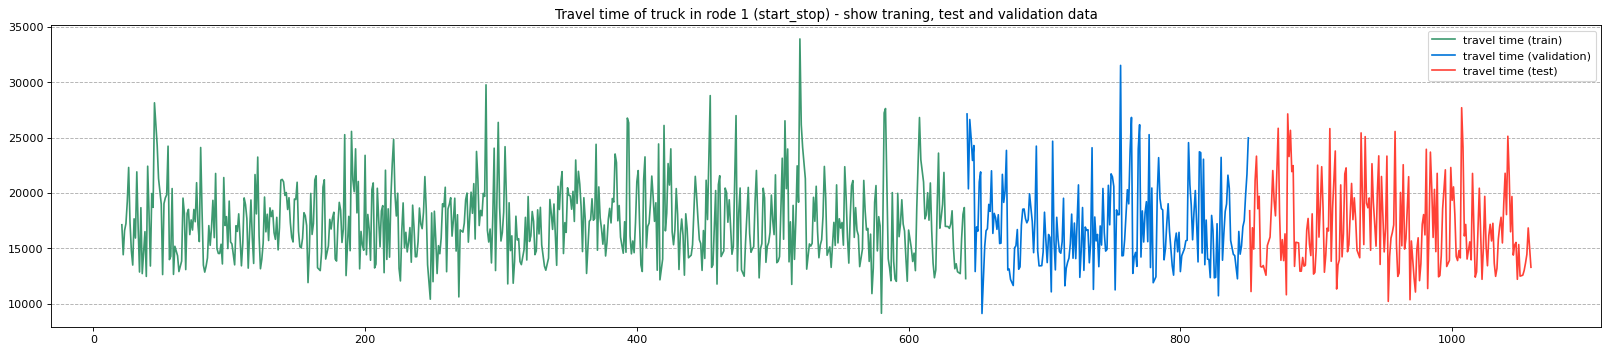

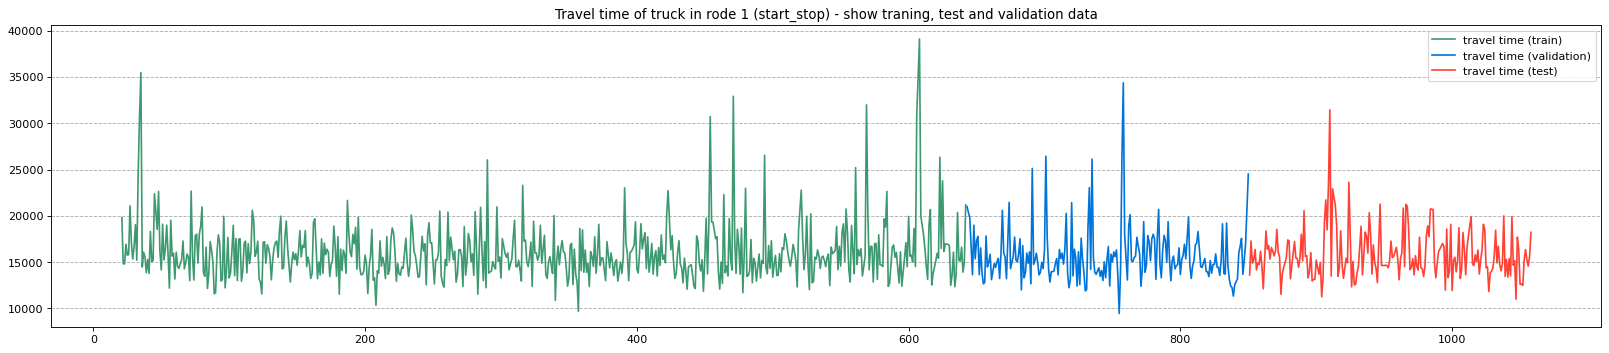

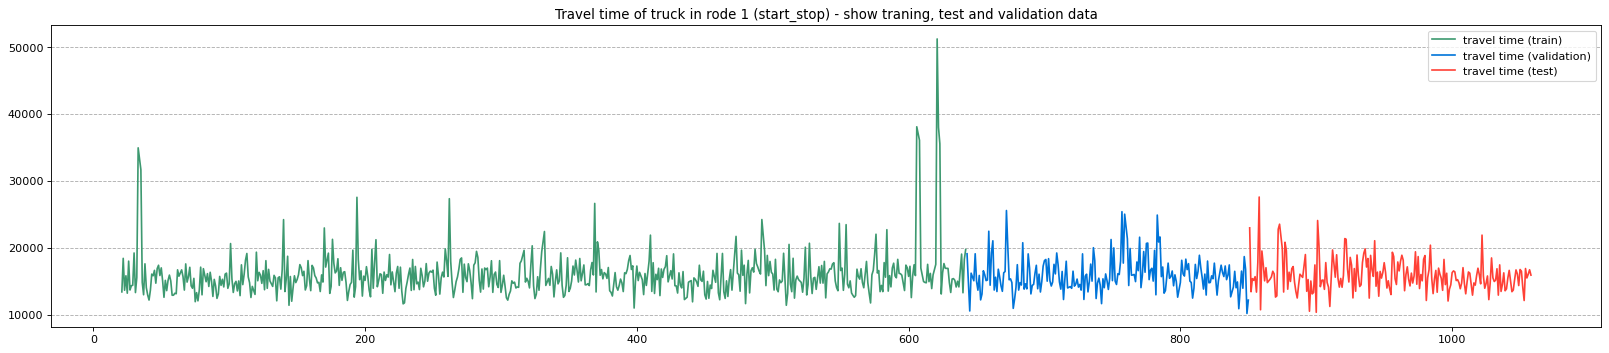

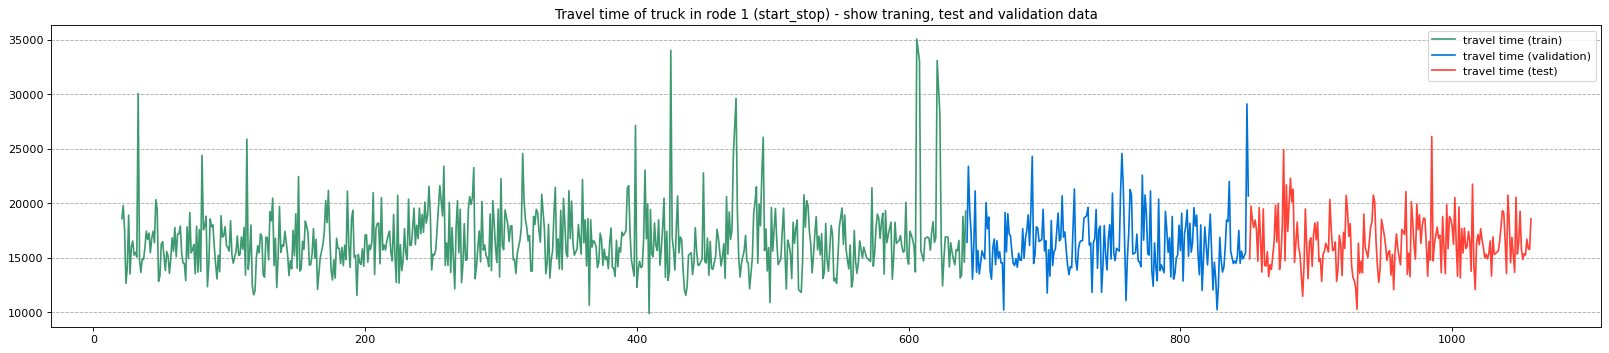

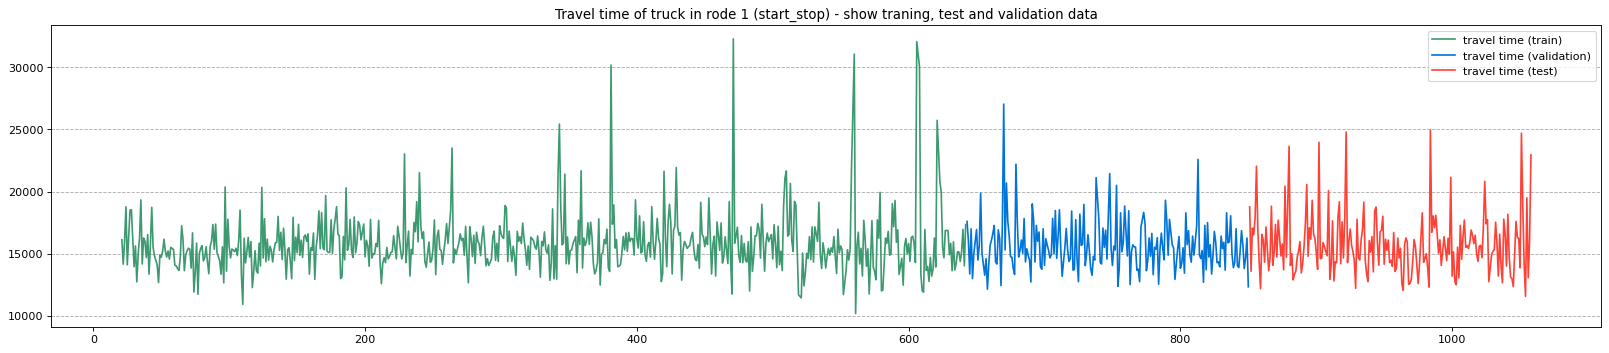

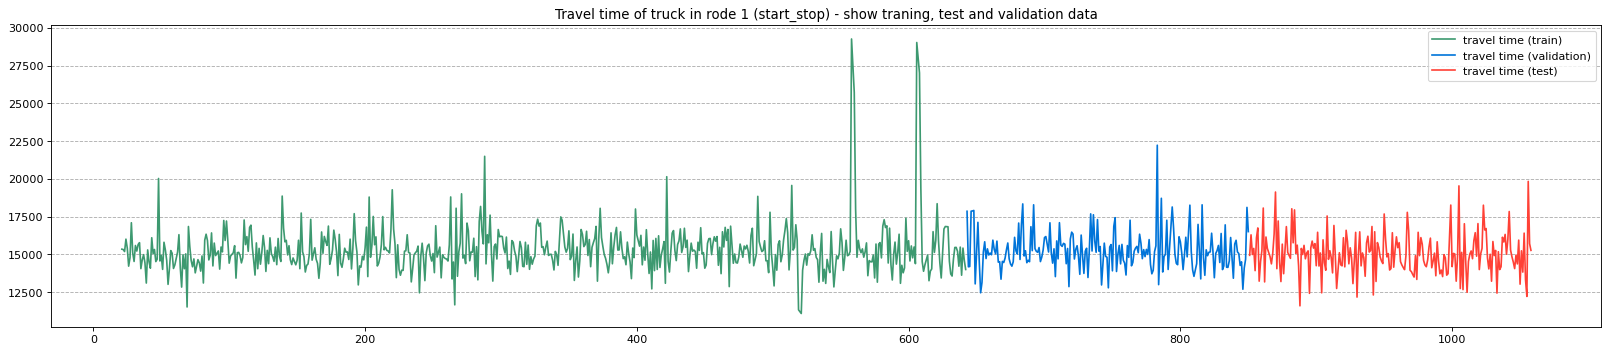

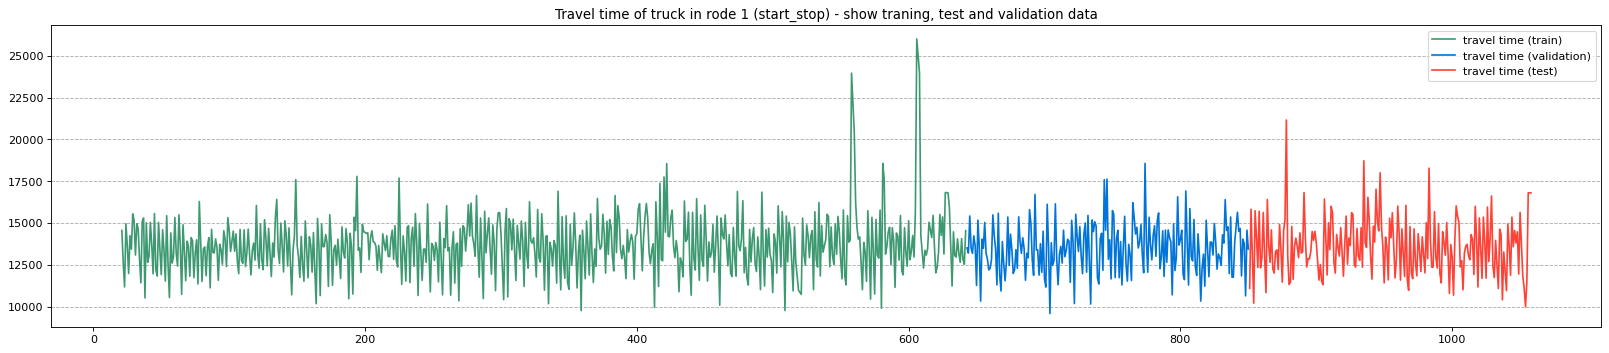

In [10]:
data_x_train_list, data_x_val_list, data_x_test_list, data_y_train_list, data_y_val_list, data_y_test_list, data_date_y_test_list, split_val_index_list = [], [], [], [], [], [], [], []
for idx in range(len(normalize_data_list)):
    data_x_train, data_x_val, data_x_test, data_y_train, data_y_val, data_y_test, data_date_y_test, _, split_val_index = generate_train_test_val(normalize_data_list[idx], num_data_points_list[idx], scaler_list[idx], cfg, True)
    data_x_train_list.append(data_x_train)
    data_x_val_list.append(data_x_val)
    data_x_test_list.append(data_x_test)
    data_y_train_list.append(data_y_train)
    data_y_val_list.append(data_y_val)
    data_y_test_list.append(data_y_test)
    data_date_y_test_list.append(data_date_y_test)
    split_val_index_list.append(split_val_index)

In [11]:
dataset_train, dataset_val, dataset_test = [], [], []
for idx in range(len(data_x_train_list)):
    dataset_train.append(TravelTimeDataset(data_x_train_list[idx], data_y_train_list[idx]))
    dataset_val.append(TravelTimeDataset(data_x_val_list[idx], data_y_val_list[idx]))
    dataset_test.append(TravelTimeDataset(data_x_test_list[idx], data_y_test_list[idx]))
    print(f"time : {idx}")
    print(f"Train data for model shape: {dataset_train[idx].x.shape} {dataset_train[idx].y.shape}")
    print(f"Validation data for model shape: {dataset_val[idx].x.shape} {dataset_val[idx].y.shape}")
    print(f"Test data for model shape: {dataset_test[idx].x.shape} {dataset_test[idx].y.shape}")

time : 0
Train data for model shape: (622, 1, 21) (622,)
Validation data for model shape: (208, 1, 21) (208,)
Test data for model shape: (208, 1, 21) (208,)
time : 1
Train data for model shape: (622, 1, 21) (622,)
Validation data for model shape: (208, 1, 21) (208,)
Test data for model shape: (208, 1, 21) (208,)
time : 2
Train data for model shape: (622, 1, 21) (622,)
Validation data for model shape: (208, 1, 21) (208,)
Test data for model shape: (208, 1, 21) (208,)
time : 3
Train data for model shape: (622, 1, 21) (622,)
Validation data for model shape: (208, 1, 21) (208,)
Test data for model shape: (208, 1, 21) (208,)
time : 4
Train data for model shape: (622, 1, 21) (622,)
Validation data for model shape: (208, 1, 21) (208,)
Test data for model shape: (208, 1, 21) (208,)
time : 5
Train data for model shape: (622, 1, 21) (622,)
Validation data for model shape: (208, 1, 21) (208,)
Test data for model shape: (208, 1, 21) (208,)
time : 6
Train data for model shape: (622, 1, 21) (622,)
V

Model Training

In [12]:
def train(dataset_train, dataset_val, model, cfg, idx, count):
    # init tool for train model
    # craete dataloader
    train_dataloader = DataLoader(dataset_train, batch_size=cfg['train']['batch_size'], shuffle=True)
    val_dataloader = DataLoader(dataset_val, batch_size=cfg['train']['batch_size'], shuffle=True)

    # define optimizer, sheduler and loss function
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=cfg['optimizer']['lr'])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=cfg['scheduler']['step_size'], gamma=0.5)
    early_stopping = EarlyStopping(patience=20, verbose=False, path=cfg['train']['checkpoint_path'])

    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = []
    
    for epoch in range(cfg['train']['num_epoch']):
        # print(f"Epoch: {epoch + 1}")

        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (x, y) in enumerate(train_dataloader):
            batch_size = x.shape[0]

            x = x.to(cfg['train']['device'])
            y = y.to(cfg['train']['device'])
            
            # prediction
            pred = model(x.float())
            loss = criterion(pred[:,0], y.float())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # add train loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (x, y) in enumerate(val_dataloader):
            batch_size = x.shape[0]

            x = x.to(cfg['train']['device'])
            y = y.to(cfg['train']['device'])

            pred = model(x.float())
            loss = criterion(pred[:,0], y.float())

            # add valid loss
            valid_losses.append(loss.item())

        # update scheduler
        lr = scheduler.get_last_lr()[0]
        scheduler.step()

        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        # print(f"[Epoch: {epoch + 1} / {cfg['train']['num_epoch']} || train_loss: {train_loss:.5f} || valid_loss: {valid_loss:.5f} || lr: {lr:.5f}]")

        train_losses = []
        valid_losses = []

        early_stopping(valid_loss, epoch, model, cfg, idx, count)

        if early_stopping.early_stop:
            # print('Early stopping')
            break

    return avg_train_losses, avg_valid_losses, early_stopping, model

Model Evaluation

In [13]:
def eval(dataset_test, data_date_y_test, split_val_index, scaler, model, cfg, best_model_name, plot=False):
    # init tool for train model
    # craete dataloader
    test_dataloader = DataLoader(dataset_test, batch_size=cfg['train']['batch_size'], shuffle=False)

    checkpoint = torch.load(os.path.join(cfg['train']['checkpoint_path'], best_model_name + '.pth'))
    model.load_state_dict(checkpoint['net'])

    predicted_test = np.array([])

    model.eval()
    for batch_idx, (x, y) in enumerate(test_dataloader):
        x = x.to(cfg['train']['device'])
        pred = model(x.float())
        pred = pred.cpu().detach().numpy()
        predicted_test = np.concatenate((predicted_test, pred[:, 0]))

    # print(dataset_test.y)
    # print(data_date_y_test.shape)

    data_test_y_series = pd.Series(dataset_test.y, index=data_date_y_test)
    predict_test_series = pd.Series(predicted_test, index=data_date_y_test)

    # print(data_test_y_series)



    # print(predict_test_series)

    mse = mean_squared_error(scaler.inverse_transform(data_test_y_series, split_val_index + cfg['data']['window_size']), scaler.inverse_transform(predict_test_series, split_val_index + cfg['data']['window_size']))
    rmse = math.sqrt(mean_squared_error(scaler.inverse_transform(data_test_y_series, split_val_index + cfg['data']['window_size']), scaler.inverse_transform(predict_test_series, split_val_index + cfg['data']['window_size'])))
    mae = mean_absolute_error(scaler.inverse_transform(data_test_y_series, split_val_index + cfg['data']['window_size']), scaler.inverse_transform(predict_test_series, split_val_index + cfg['data']['window_size']))

    # print(f"MSE : {mse}")
    # print(f"RMSE : {rmse}")
    # print(f"MAE : {mae}")
    print(scaler.inverse_transform(data_test_y_series, split_val_index + cfg['data']['window_size']))
    print(scaler.inverse_transform(predict_test_series, split_val_index + cfg['data']['window_size']))

    if plot:
        road = (cfg['data']['path'].split('/')[-1]).split('.')[0]
        path = cfg['data']['path'].split('/')[-2]

        to_plot_data_y_test_subset = scaler.inverse_transform(data_test_y_series, split_val_index + cfg['data']['window_size'])
        to_plot_predicted_test = scaler.inverse_transform(predict_test_series, split_val_index + cfg['data']['window_size'])

        idx = np.arange(0, len(data_date_y_test))

        #plot
        fig = plt.figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(idx, to_plot_data_y_test_subset, label='Actual travel time', color=cfg['plots']['color_actual'])
        plt.plot(idx, to_plot_predicted_test, label='Predicted travel time (test)', color=cfg['plots']['color_pred_test'])
        plt.title(f"Examine predicted travel time on test data portion of road {road} ({path}) [MSE: {mse:.3f} | RMSE: {rmse:.3f} | MAE: {mae:.3f}]")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()

    return mse, rmse, mae

Modify

2019-10-23 02:00:00    18392.0
2019-10-24 00:00:00    11090.0
2019-10-24 01:00:00    16855.0
2019-10-24 02:00:00    14928.0
2019-10-25 00:00:00    21127.8
                        ...   
2019-12-30 01:00:00    13661.0
2019-12-30 02:00:00    14449.5
2019-12-31 00:00:00    16838.0
2019-12-31 01:00:00    15060.5
2019-12-31 02:00:00    13283.0
Length: 208, dtype: float64
2019-10-23 02:00:00    24980.773898
2019-10-24 00:00:00    18564.266665
2019-10-24 01:00:00    14376.555131
2019-10-24 02:00:00    16979.984490
2019-10-25 00:00:00    16599.706188
                           ...     
2019-12-30 01:00:00    15685.686158
2019-12-30 02:00:00    15463.606346
2019-12-31 00:00:00    15565.788105
2019-12-31 01:00:00    17006.748432
2019-12-31 02:00:00    15647.199567
Length: 208, dtype: float64


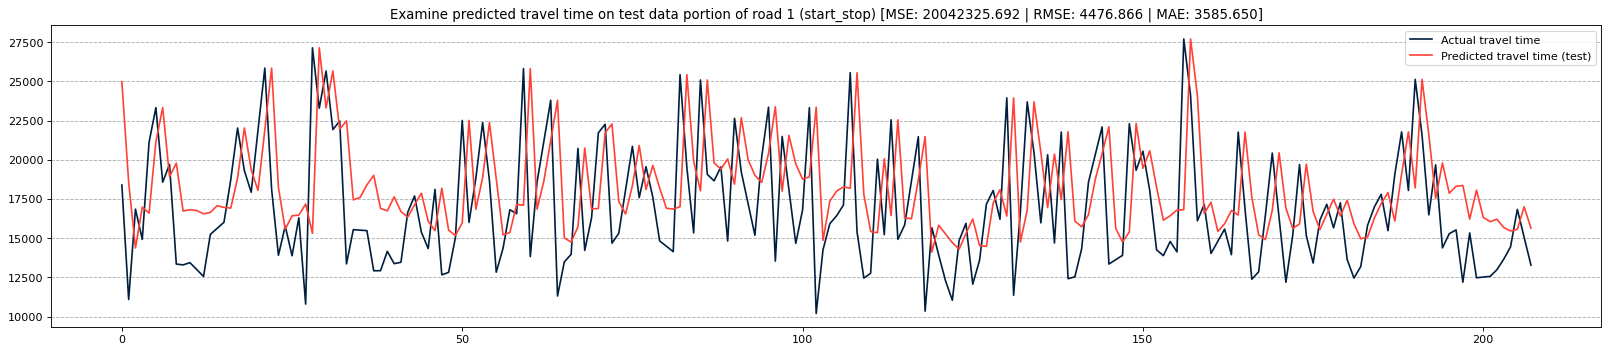

time : 0
MSE : 20042325.691506628 || RMSE : 4476.865610168193 || MAE : 3585.6504477306885
2019-10-23 05:00:00    13620.333333
2019-10-24 03:00:00    17282.000000
2019-10-24 04:00:00    14896.000000
2019-10-24 05:00:00    15261.000000
2019-10-25 03:00:00    16368.500000
                           ...     
2019-12-30 04:00:00    16359.000000
2019-12-30 05:00:00    15279.000000
2019-12-31 03:00:00    14573.000000
2019-12-31 04:00:00    15617.333333
2019-12-31 05:00:00    18222.000000
Length: 208, dtype: float64
2019-10-23 05:00:00    24513.021779
2019-10-24 03:00:00    15371.973553
2019-10-24 04:00:00    17359.306955
2019-10-24 05:00:00    15864.232323
2019-10-25 03:00:00    16180.227713
                           ...     
2019-12-30 04:00:00    15345.057628
2019-12-30 05:00:00    16393.705984
2019-12-31 03:00:00    15462.285661
2019-12-31 04:00:00    14867.329902
2019-12-31 05:00:00    15717.722865
Length: 208, dtype: float64


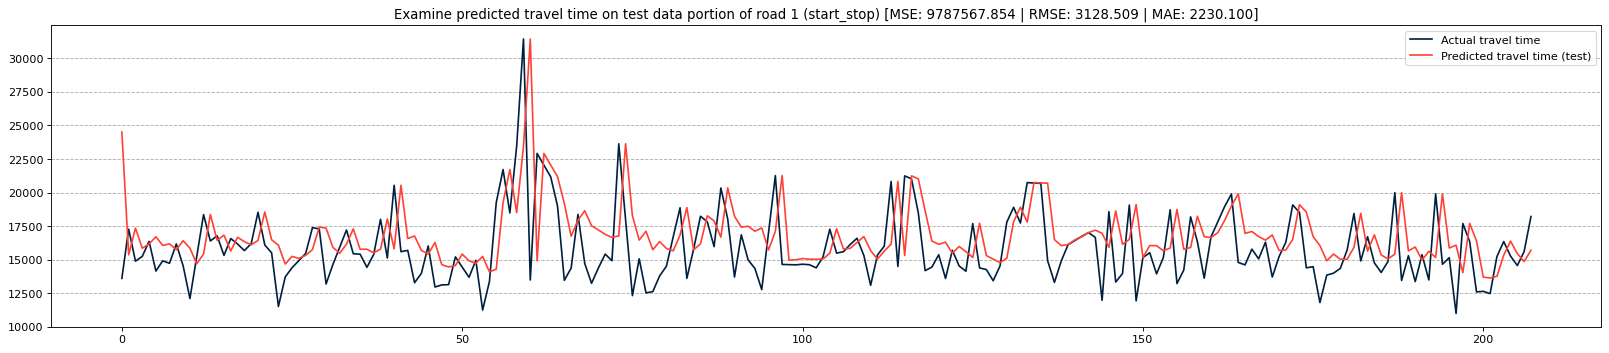

time : 1
MSE : 9787567.853656799 || RMSE : 3128.5088866194383 || MAE : 2230.099881676521
2019-10-23 08:00:00    22975.00
2019-10-24 06:00:00    13419.50
2019-10-24 07:00:00    15382.25
2019-10-24 08:00:00    15123.00
2019-10-25 06:00:00    15680.00
                         ...   
2019-12-30 07:00:00    16893.50
2019-12-30 08:00:00    15480.00
2019-12-31 06:00:00    16037.00
2019-12-31 07:00:00    16705.00
2019-12-31 08:00:00    15903.50
Length: 208, dtype: float64
2019-10-23 08:00:00    12400.153635
2019-10-24 06:00:00    22975.035850
2019-10-24 07:00:00    13459.860373
2019-10-24 08:00:00    15391.601604
2019-10-25 06:00:00    15162.517840
                           ...     
2019-12-30 07:00:00    13802.540417
2019-12-30 08:00:00    16920.763151
2019-12-31 06:00:00    15754.504938
2019-12-31 07:00:00    16196.991700
2019-12-31 08:00:00    16817.770153
Length: 208, dtype: float64


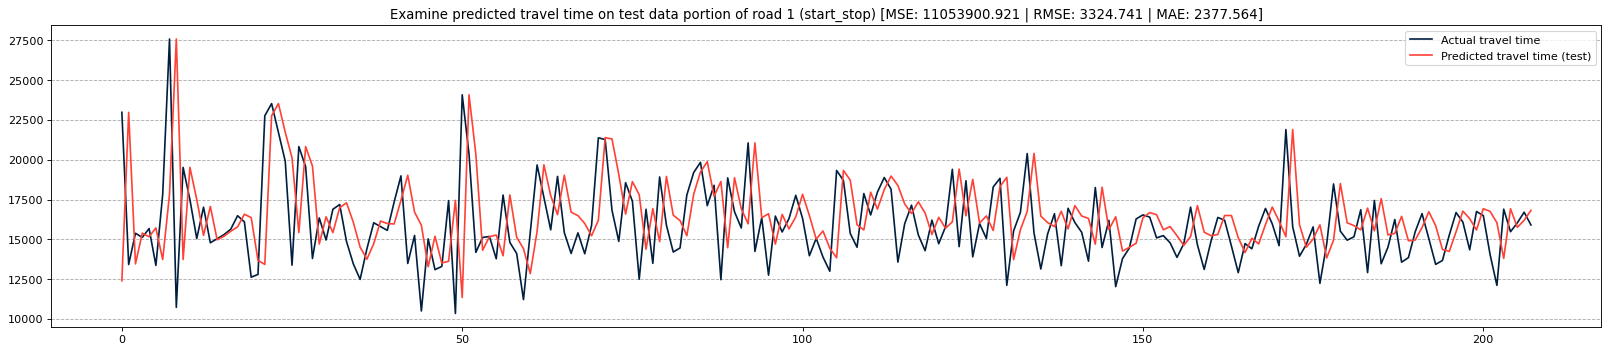

time : 2
MSE : 11053900.920849223 || RMSE : 3324.7407298689054 || MAE : 2377.5643161236085
2019-10-23 11:00:00    14898.000000
2019-10-24 09:00:00    19731.000000
2019-10-24 10:00:00    18455.000000
2019-10-24 11:00:00    17764.000000
2019-10-25 09:00:00    18447.500000
                           ...     
2019-12-30 10:00:00    15247.500000
2019-12-30 11:00:00    16693.500000
2019-12-31 09:00:00    15829.916667
2019-12-31 10:00:00    15756.333333
2019-12-31 11:00:00    18565.000000
Length: 208, dtype: float64
2019-10-23 11:00:00    20684.589041
2019-10-24 09:00:00    17082.578940
2019-10-24 10:00:00    19740.436303
2019-10-24 11:00:00    18590.006493
2019-10-25 09:00:00    18270.051438
                           ...     
2019-12-30 10:00:00    17750.280327
2019-12-30 11:00:00    17712.285385
2019-12-31 09:00:00    17826.186530
2019-12-31 10:00:00    17546.667050
2019-12-31 11:00:00    17338.711165
Length: 208, dtype: float64


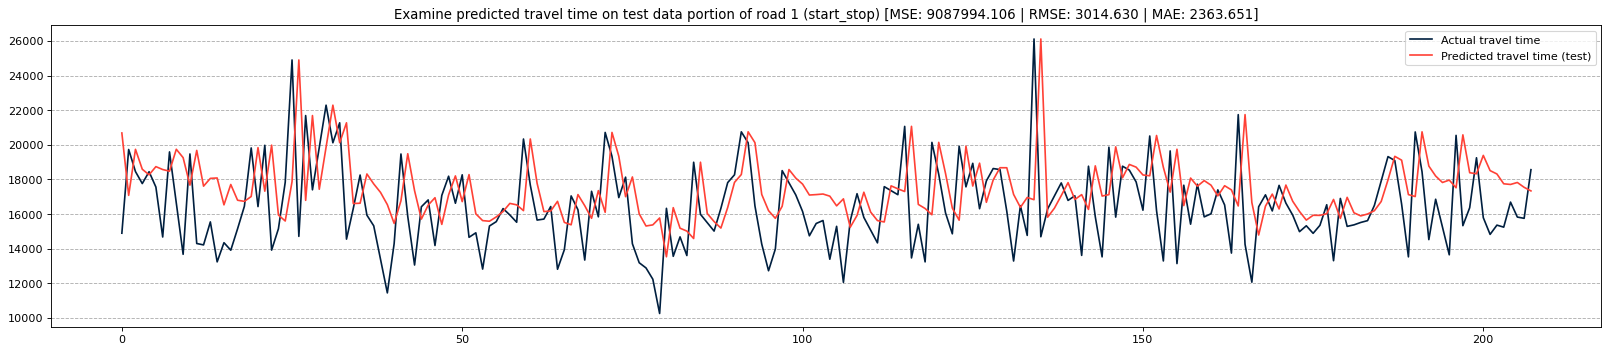

time : 3
MSE : 9087994.106343536 || RMSE : 3014.630011517754 || MAE : 2363.650788958356


KeyboardInterrupt: 

In [14]:
result = []
for idx in range(len(dataset_train)):
    model = ConvLSTMTravelTime(num_channels=1,num_kernels=64,kernel_size=3,padding=1,num_layers=1)
    #model.apply(init_weights)
    if torch.cuda.is_available():
        cfg['train']['device'] = 'cuda'
    else:
        cfg['train']['device'] = 'cpu'
    model = model.to(cfg['train']['device'])

    train_losses, valid_losses, early_stopping, model = train(dataset_train[idx], dataset_val[idx], model, cfg, idx, 0)

    mse, rmse, mae = eval(dataset_test[idx], data_date_y_test_list[idx], split_val_index_list[idx], scaler_list[idx], model, cfg, f"cnn_lstm_time_{idx}_{0}", True)

    print(f"time : {idx}")
    print(f"MSE : {mse} || RMSE : {rmse} || MAE : {mae}")
    print(f"==================================================================================")

    result.append({
        'name': f"time-{idx}",
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
    })